#### Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import RandomOverSampler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from matplotlib import pyplot
import timeit

Some interesting questions to address
1. To which segment of the population is the marketing campaign going to address and why?
2. Which instrument should we use to get our message out? (Ex: Telephones, Radio, TV, Social Media Etc.)
3. What is the best price to offer to potential clients?
4. indepth analysis of previous campaigns (If possible) in order to learn from previous mistakes and to determine how to make the marketing campaign much more effective.

#### Potential steps
1. plot model performance using f1 score
2. explanatory data analysis

# Data Prepocessing

### Import Dataset

Dataset Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing?package=regsel&version=0.2<br>
> Before implementing the following code, make sure 'bank-additional-full.csv' is in directory './data/bank-additional'<br>
- semi-colon separated file
- read 'unknown' as na
- 41188 observations, 21 variables

In [2]:
# use !pwd to check the current working directory
df = pd.read_csv("./data/bank-additional/bank-additional-full.csv", sep = ';')

### Data Overview

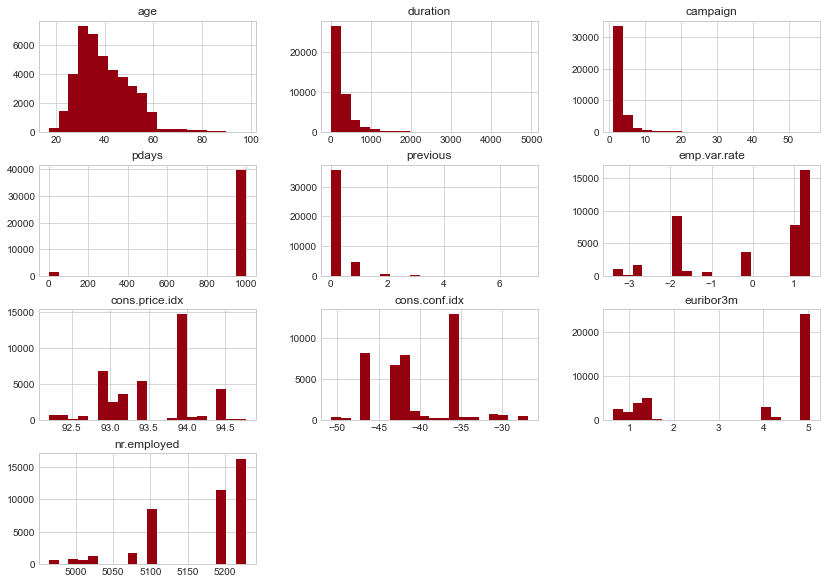

In [3]:
plt.style.use('seaborn-whitegrid')

df.hist(bins=20, figsize=(14,10), color='#950010')
plt.show()

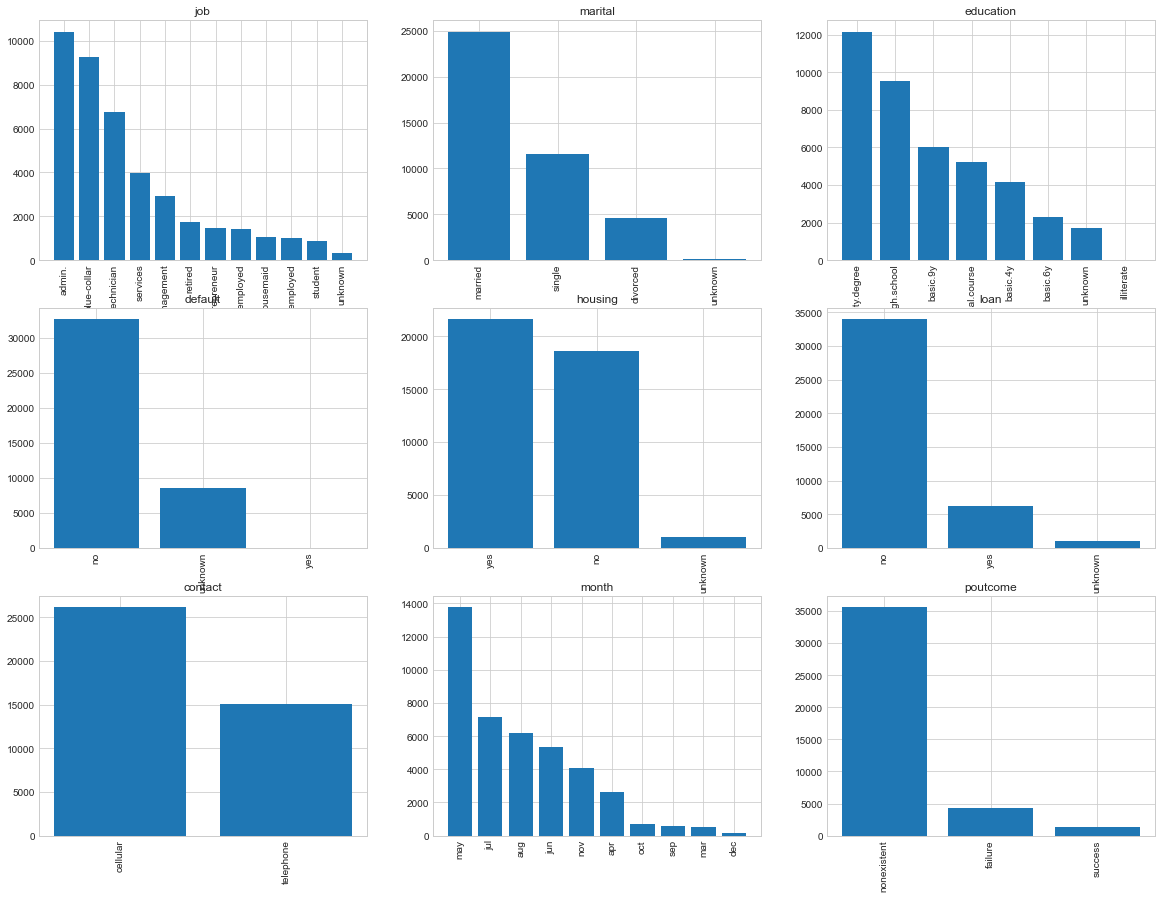

In [4]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

In [5]:
df = pd.read_csv("./data/bank-additional/bank-additional-full.csv", sep = ';', na_values = 'unknown')

- showing levels for categorical variables
- there are missing values in variables jon, marital, education, default, housing, loan, y

In [6]:
for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())

job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' nan 'entrepreneur' 'student']
marital
['married' 'single' 'divorced' nan]
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course' nan
 'university.degree' 'illiterate']
default
['no' nan 'yes']
housing
['no' 'yes' nan]
loan
['no' 'yes' nan]
contact
['telephone' 'cellular']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
poutcome
['nonexistent' 'failure' 'success']
y
['no' 'yes']


In [7]:
print(df.isnull().sum())
print(df.columns)
print(df.shape)
print(df.info())
print(df.describe())

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
(41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  ----- 

<AxesSubplot:ylabel='y'>

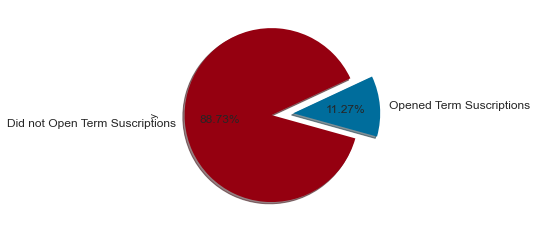

In [8]:

labels ="Did not Open Term Suscriptions", "Opened Term Suscriptions"
df["y"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%',  shadow=True, 
                                colors=["#950010", "#006d9c"], 
                                labels=labels, fontsize=12, startangle=25)

### Data cleaning

Standardize all the numeric variables. This is helpful for distance based machine learning algorithms like knn

In [9]:
# select all the numeric columns
col_numeric = list(df.select_dtypes(include=[np.number]).columns.values)
scaler = StandardScaler()
df[col_numeric] = scaler.fit_transform(df[col_numeric])
print(df.columns)
print(df.shape)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
(41188, 21)


- Drop the variable **duration**. (data description: "Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.")
- duration is obtained after the call is made to the potential client so **if the target client has never received calls this feature is not that useful**. We can build a model that is capable to predict the chance of a customer subscripe a product BEFORE the contact is made. That's why we must drop duration.
- Shown as above: total number of missing values in job, marital, education, default, housing, loan
- Drop observations of variables with missing values less than 1000: job, marital, housing, loan
- For variables with missing values more than 1000 (education, default), regard missing values as a new factor level
- For each categorical variables, the number of observations of each factor levels is shown as below
- 41188 --> 39803 observations

In [10]:
df = df.drop('duration', axis=1)
df = df[df['job'].notna()]
df = df[df['marital'].notna()]
df = df[df['housing'].notna()]
df = df[df['loan'].notna()]
df.education = df.education.fillna('unknown')
df.default = df.default.fillna('unknown')
print(df.job.value_counts())
print(df.marital.value_counts())
print(df.education.value_counts())
print(df.default.value_counts())
print(df.housing.value_counts())
print(df.loan.value_counts())

admin.           10181
blue-collar       9001
technician        6584
services          3862
management        2850
retired           1671
entrepreneur      1417
self-employed     1376
housemaid         1028
unemployed         982
student            851
Name: job, dtype: int64
married     24110
single      11215
divorced     4478
Name: marital, dtype: int64
university.degree      11821
high.school             9244
basic.9y                5856
professional.course     5100
basic.4y                4002
basic.6y                2204
unknown                 1558
illiterate                18
Name: education, dtype: int64
no         31587
unknown     8213
yes            3
Name: default, dtype: int64
yes    21376
no     18427
Name: housing, dtype: int64
no     33620
yes     6183
Name: loan, dtype: int64


- convert y, loan, housing as binary variables with level 1, 0
- perform ordinal encoding on month and day_of_week
- convert to dummy variables in the form of **VariableName_FactorLevel**: 'job', 'marital', 'education', 'contact', 'default', 'poutcome'

In [11]:
df[['y', 'loan', 'housing']] = df[['y', 'loan', 'housing']].replace('yes', 1)
df[['y', 'loan', 'housing']] = df[['y', 'loan', 'housing']].replace('no', 0)
df['month'] = df['month'].replace('mar', 0)
df['month'] = df['month'].replace('apr', 1)
df['month'] = df['month'].replace('may', 2)
df['month'] = df['month'].replace('jun', 3)
df['month'] = df['month'].replace('jul', 4)
df['month'] = df['month'].replace('aug', 5)
df['month'] = df['month'].replace('sep', 6)
df['month'] = df['month'].replace('oct', 7)
df['month'] = df['month'].replace('nov', 8)
df['month'] = df['month'].replace('dec', 9)
df['day_of_week'] = df['day_of_week'].replace('mon', 0)
df['day_of_week'] = df['day_of_week'].replace('tue', 1)
df['day_of_week'] = df['day_of_week'].replace('wed', 2)
df['day_of_week'] = df['day_of_week'].replace('thu', 3)
df['day_of_week'] = df['day_of_week'].replace('fri', 4)
cat_columns = ['job', 'marital', 'education', 'contact', 'default', 'poutcome']
for col in  cat_columns:
    df = pd.concat([df.drop(col, axis=1),
                    pd.get_dummies(df[col], prefix=col, prefix_sep='_',
                                   drop_first=True, dummy_na=False)], axis=1)
df.head()

,age,housing,loan,month,day_of_week,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_telephone,default_unknown,default_yes,poutcome_nonexistent,poutcome_success
0,1.533034,0,0,2,0,-0.565922,0.195414,-0.349494,0.648092,0.722722,...,0,0,0,0,0,1,0,0,1,0
1,1.628993,0,0,2,0,-0.565922,0.195414,-0.349494,0.648092,0.722722,...,1,0,0,0,0,1,1,0,1,0
2,-0.290186,1,0,2,0,-0.565922,0.195414,-0.349494,0.648092,0.722722,...,1,0,0,0,0,1,0,0,1,0
3,-0.002309,0,0,2,0,-0.565922,0.195414,-0.349494,0.648092,0.722722,...,0,0,0,0,0,1,0,0,1,0
4,1.533034,0,1,2,0,-0.565922,0.195414,-0.349494,0.648092,0.722722,...,1,0,0,0,0,1,0,0,1,0


In [12]:
print(df.y.value_counts())
print(df.shape)

0    35316
1     4487
Name: y, dtype: int64
(39803, 38)


# Model fitting

In [13]:
# set all of the random states to be 123
seed = 123

#### Help function
- conf_matrix: return a pretty plot of confusion matrix
- get_scores: return accuracy, 

In [14]:
def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3,3))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False)
    plt.title('Accept Deposit?')
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    
def get_scores(y, y_pred, y_prob):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),3),
    'Precision':np.round(precision_score(y, y_pred),3),
    'Recall':np.round(recall_score(y, y_pred),3),
    'F1':np.round(f1_score(y, y_pred),3),
    'ROC AUC':np.round(roc_auc_score(y, y_prob),3)}
    scores_df = pd.Series(data).to_frame('scores')
    return scores_df

### Baseline Model: logistic regression (first try)
First
- using all variables in the dataset
- using stratified splits
- training and test datasets have extremely inbalanced data
There is high accuracy but low F1 score. The high accuracy is not informative.

(29852, 37)
(9951, 37)


,scores
Accuracy,0.899
Precision,0.665
Recall,0.201
F1,0.309
ROC AUC,0.784


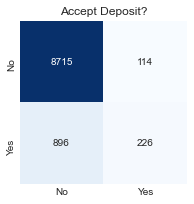

In [15]:
X = df.drop('y', axis=1).values
y = df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed, stratify = y)
print(X_train.shape)
print(X_test.shape)
glr_model = LogisticRegression(max_iter = 500, random_state=seed)
glr_model.fit(pd.DataFrame(X_train), y_train)
y_pred_glr = glr_model.predict(pd.DataFrame(X_test))
y_prob_glr = glr_model.predict_proba(pd.DataFrame(X_test))
conf_matrix(y_test, y_pred_glr)
get_scores(y_test, y_pred_glr, y_prob_glr[:, 1])


### Final Baseline Model
After stratified sampling and resample a balanced test dataset. The accuracy is much lower, and no change to ROC AUC, but with higher F1 score. This will be used as the baseline model instead.

(29852, 37)
(2244, 37)


,scores
Accuracy,0.593
Precision,0.930
Recall,0.201
F1,0.331
ROC AUC,0.786


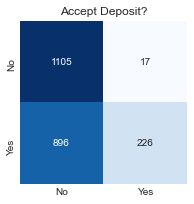

In [16]:
X = df.drop('y', axis=1).values
y = df['y'].values
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.25, random_state=seed, stratify = y)

X_yes_full = X_test_full[y_test_full == 1]
X_no_full  = X_test_full[y_test_full == 0]
np.random.seed(seed)
X_no_full = X_no_full[np.random.randint(X_no_full.shape[0], size=X_yes_full.shape[0]),:]

X_test_full = pd.concat([pd.DataFrame(X_no_full), pd.DataFrame(X_yes_full)], join="inner").values
y_test_full = [0] * X_no_full.shape[0] + [1] * X_no_full.shape[0]
print(X_train_full.shape)
print(X_test_full.shape)
glr_model.fit(pd.DataFrame(X_train_full), y_train_full)
y_pred_glr_full = glr_model.predict(pd.DataFrame(X_test_full))
y_prob_glr_full = glr_model.predict_proba(X_test_full)
conf_matrix(y_test_full, y_pred_glr_full)
get_scores(y_test_full, y_pred_glr_full, y_prob_glr_full[:, 1])

#### Final baseline model parameters

In [17]:
pd.DataFrame(zip(df.drop('y', axis=1).columns, np.transpose(glr_model.coef_)), columns=['features', 'coef']) 

,features,coef
0,age,[0.026606000536758996]
1,housing,[-0.004305678870672083]
2,loan,[-0.037690203903658286]
3,month,[-0.0601508975509772]
4,day_of_week,[0.04606750470870634]
5,campaign,[-0.10590143460408784]
6,pdays,[-0.22554897812228303]
7,previous,[-0.0178722747992727]
8,emp.var.rate,[-1.3897202010477367]
9,cons.price.idx,[0.6462513697875362]


### Feature selection
GOAL: 
1. We want to improve the computational efficiency 
2. reduce the generalization error of the model by removing irrelevant features or noise
3. Since our primary goal is to help with client profiling and identify prospective clients, there should not be a large amount of predictors or layers in our model, and it’s better that the predictors in our model can be easily collected. 
- get the top 10 important variables 
- by correlation, random forest, xgboost
- put 17 different variables into sequential feature selector to get final top 10 variables

Text(0.5, 0, 'correlation Feature Importance')

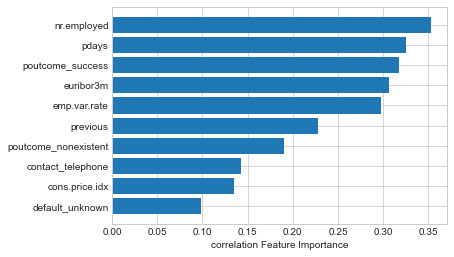

In [18]:
# remove y (index 13: HARDCODED!! NEED TO CHANGE!!)
cor = df.corr()['y'][:].drop(df.corr()['y'][:].index[13]).abs()

sorted_idx_cor = cor.argsort()

plt.barh(df.drop('y', 1).columns[sorted_idx_cor[-10:]], cor[sorted_idx_cor[-10:]])
plt.xlabel("correlation Feature Importance")

[08:08:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.5, 0, 'Xgboost Feature Importance')

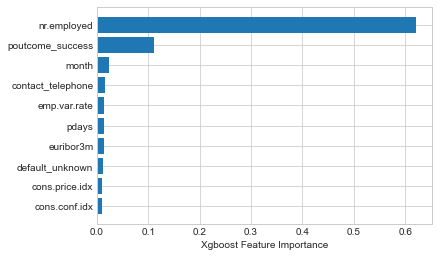

In [19]:
# fit model no training data
model = XGBClassifier(use_label_encoder =False)
model.fit(df.drop('y', 1), df['y'])
sorted_idx_xgb = model.feature_importances_.argsort()
plt.barh(df.drop('y', 1).columns[sorted_idx_xgb[-10:]], model.feature_importances_[sorted_idx_xgb[-10:]])
plt.xlabel("Xgboost Feature Importance")

Text(0.5, 0, 'rf Feature Importance')

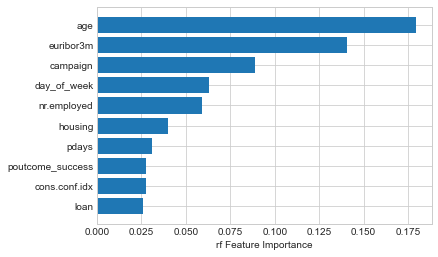

In [20]:
rf = RandomForestClassifier()
rf.fit(df.drop('y', 1), df['y'])

sorted_idx_rf = rf.feature_importances_.argsort()
plt.barh(df.drop('y', 1).columns[sorted_idx_rf[-10:]], rf.feature_importances_[sorted_idx_rf[-10:]])
plt.xlabel("rf Feature Importance")

df_features_pre contain 17 variables that are selected from correlation, random forest, xgboost.<br>
It does not contain the target variable.

In [21]:
# put all the top 10 important variables from 3 different methods in one dataframe
x = df.drop('y', 1).columns[sorted_idx_rf[-10:]]
x = x.append(df.drop('y', 1).columns[sorted_idx_xgb[-10:]])
x = x.append(df.drop('y', 1).columns[sorted_idx_cor[-10:]])
df_features_pre = df.loc[:, df.columns.isin(x)]
df_features_pre.shape

(39803, 17)

In [22]:
sfs1 = SFS(glr_model, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=0)

sfs1 = sfs1.fit(df_features_pre, df['y'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.4s finished

[2021-12-06 08:09:00] Features: 1/10 -- score: 0.7480362942006638[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.4s finished

[2021-12-06 08:09:00] Features: 2/10 -- score: 0.7654672773484407[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.5s finished

[2021-12-06 08:09:01] Features: 3/10 -- score: 0.7695920506108143[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

df_features contain 10 variables selected from sequential feature selector

In [23]:
#df_features = df_features_pre
print(list(sfs1.k_feature_idx_))
df_features = df_features_pre.iloc[:, list(sfs1.k_feature_idx_)]
df_features.columns

[1, 6, 7, 8, 10, 11, 12, 13, 15, 16]


Index(['housing', 'pdays', 'previous', 'emp.var.rate', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'contact_telephone', 'poutcome_nonexistent',
       'poutcome_success'],
      dtype='object')

#### Logistic regression with selected features compared with baseline model
Train/test split: first apply stratified sampling and then resample the test dataset to make it balanced<br>
Training dataset is imbalanced. Test dataset is balanced.<br>
The evaluation metric stayed pretty much the same compared with the baseline model. However, the features selection is able to reduce the dimensionality of the predictive models. While the dimensionality of the model decreases, the complexity of the model also decreases. This eventually leads to a faster model training time and convergence. It is reasonable to apply feature selection to reduces the model complexity, training time and overfitting while increasing the generalization ability.<br>
In following analysis, we will train model **with feature selection and without feature selection**<br>
There is no significant improvement in performance. We will try **oversampling** later to check if there is an improvement

,scores
Accuracy,0.580
Precision,0.937
Recall,0.171
F1,0.289
ROC AUC,0.785


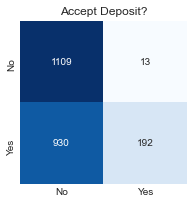

In [24]:
X = df_features.values
y = df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed, stratify = y)
X_yes = X_test[y_test == 1]
X_no  = X_test[y_test == 0]
np.random.seed(seed)
X_no = X_no[np.random.randint(X_no.shape[0], size=X_yes.shape[0]),:]

X_test = pd.concat([pd.DataFrame(X_no), pd.DataFrame(X_yes)], join="inner").values
y_test = [0] * X_no.shape[0] + [1] * X_no.shape[0]

glr_model.fit(pd.DataFrame(X_train), y_train)
y_pred_glr = glr_model.predict(pd.DataFrame(X_test))
y_prob_glr = glr_model.predict_proba(X_test)
conf_matrix(y_test,y_pred_glr)
get_scores(y_test,y_pred_glr, y_prob_glr[:, 1])

### Train/Validation/Test Split

To tackle inbalanced target variable:
1. change the performance metric (accuracy is misleading, using confusion matrix, recall, precision, F1 score instead, ROC curves)
2. Set classier parameter "class_weight" to "balanced"
3. create a balanced test set and validation set for better comparison between models. The training set will still be inbalanced.

In [25]:
df.y.value_counts()

0    35316
1     4487
Name: y, dtype: int64

#### 3 different train/test split
All test datasets are balanced.<br>
1. stratified splits on dataset with feature selection
2. stratified splits on dataset without feature selection
3. oversample on training dataset with feature selection.

#### inbalanced -- 10 variables
train and test datasets with only 10 selected variables

In [26]:
X = df_features.values
y = df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed, stratify = y)

X_yes = X_test[y_test == 1]
X_no  = X_test[y_test == 0]
np.random.seed(seed)
X_no = X_no[np.random.randint(X_no.shape[0], size=X_yes.shape[0]),:]

X_test = pd.concat([pd.DataFrame(X_no), pd.DataFrame(X_yes)], join="inner").values
y_test = [0] * X_no.shape[0] + [1] * X_no.shape[0]


print(X_train.shape)
print(X_test.shape)

(29852, 10)
(2244, 10)


#### inbalanced -- 38 variables
train and test datasets with all 38 variables

In [27]:
X = df.drop('y', axis=1).values
y = df['y'].values
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.25, random_state=seed, stratify = y)

X_yes_full = X_test_full[y_test_full == 1]
X_no_full  = X_test_full[y_test_full == 0]
np.random.seed(seed)
X_no_full = X_no_full[np.random.randint(X_no_full.shape[0], size=X_yes_full.shape[0]),:]

X_test_full = pd.concat([pd.DataFrame(X_no_full), pd.DataFrame(X_yes_full)], join="inner").values
y_test_full = [0] * X_no_full.shape[0] + [1] * X_no_full.shape[0]
print(X_train_full.shape)
print(X_test_full.shape)

(29852, 37)
(2244, 37)


#### oversampling -- 10 variables
The test dataset is a balanced dataset by applying the same procedure as above. The training dataset generated from over sampling

In [28]:
oversample = RandomOverSampler(sampling_strategy='minority')
X = df_features.values
y = df['y'].values

X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
print(X_train_over.shape)
print(X_test.shape)
print(np.count_nonzero(y_train_over == 0))
print(np.count_nonzero(y_train_over == 1))

(52974, 10)
(2244, 10)
26487
26487


#### compare undersampling with baseline logistic regression 

,scores
Accuracy,0.734
Precision,0.772
Recall,0.662
F1,0.713
ROC AUC,0.785


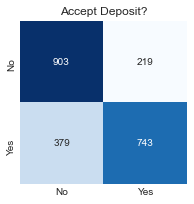

In [29]:
import time
t1 = time.time()
glr_model.fit(pd.DataFrame(X_train_over), y_train_over)
y_pred_glr_over = glr_model.predict(pd.DataFrame(X_test))
y_prob_glr_over = glr_model.predict_proba(X_test)
t2 = time.time()
t_glr = t2-t1
conf_matrix(y_test,y_pred_glr_over)
get_scores(y_test,y_pred_glr_over, y_prob_glr_over[:, 1])

In [30]:
pd.DataFrame(zip(df.drop('y', axis=1).columns, np.transpose(glr_model.coef_)), columns=['features', 'coef']) 

,features,coef
0,age,[-0.014074948445410624]
1,housing,[-0.24761099144907903]
2,loan,[-0.001155302377510633]
3,month,[-0.6948295026730863]
4,day_of_week,[0.005572773263204573]
5,campaign,[1.0303408925613144]
6,pdays,[-1.0804951166774646]
7,previous,[-0.6935958911336692]
8,emp.var.rate,[0.5662287679712776]
9,cons.price.idx,[0.7213855811772861]


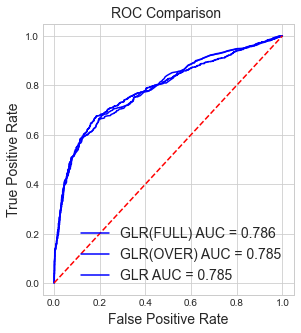

In [31]:
fprglr_over, tprglr_over, _ = roc_curve(y_test, y_prob_glr_over[:, 1])
fprglr_full, tprglr_full, _ = roc_curve(y_test, y_prob_glr_full[:, 1])
fprglr, tprglr, _ = roc_curve(y_test, y_prob_glr[:, 1])
roc_aucglr_full = auc(fprglr_full, tprglr_full)
roc_aucglr_over = auc(fprglr_over, tprglr_over)
roc_aucglr = auc(fprglr, tprglr)

fig = plt.figure(figsize=(4.5,5))
plt.plot(fprglr_full, tprglr_full, 'b', label='GLR(FULL) AUC = %0.3f' % roc_aucglr_full)
plt.plot(fprglr_over, tprglr_over, 'b', label='GLR(OVER) AUC = %0.3f' % roc_aucglr_over)
plt.plot(fprglr, tprglr, 'b', label='GLR AUC = %0.3f' % roc_aucglr)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Comparison ',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.legend(loc = 'lower right', prop={'size': 14})

Logistic: f1=0.289 auc=0.808
Logistic_over: f1=0.713 auc=0.805
Logistic_full: f1=0.331 auc=0.811


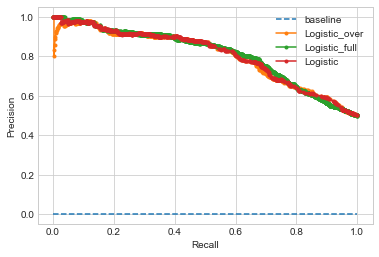

In [32]:
from sklearn.metrics import precision_recall_curve, f1_score
lr_precision_over, lr_recall_over, _ = precision_recall_curve(y_test, y_prob_glr_over[:, 1])
lr_auc_over, lr_f1_over = auc(lr_recall_over, lr_precision_over), f1_score(y_test, y_pred_glr_over)
lr_precision_full, lr_recall_full, _ = precision_recall_curve(y_test, y_prob_glr_full[:, 1])
lr_auc_full, lr_f1_full = auc(lr_recall_full, lr_precision_full), f1_score(y_test, y_pred_glr_full)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_prob_glr[:, 1])
lr_auc, lr_f1 = auc(lr_recall, lr_precision), f1_score(y_test, y_pred_glr)


#lr_f1, lr_auc = f1_score(y_test, y_prob_glr_over[:, 1]), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('Logistic_over: f1=%.3f auc=%.3f' % (lr_f1_over, lr_auc_over))
print('Logistic_full: f1=%.3f auc=%.3f' % (lr_f1_full, lr_auc_full))
# plot the precision-recall curves
no_skill = np.count_nonzero(y_test==1) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='baseline')
pyplot.plot(lr_recall_over, lr_precision_over, marker='.', label='Logistic_over')
pyplot.plot(lr_recall_full, lr_precision_full, marker='.', label='Logistic_full')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

#### Hyperparameter tuning

In [33]:
"""
from sklearn.model_selection import GridSearchCV
#knn
grid_params_knn = { 'n_neighbors' : [50, 100, 150, 200, 250, 300],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs_knn = GridSearchCV(KNeighborsClassifier(), grid_params_knn, verbose = 1, cv=3, n_jobs = -1)
gs_knn_res = gs.fit(X_train, y_train)
gs_knn_res.best_params_

#adaboost
grid_params_abc = {'n_estimators':[10, 50, 100, 500, 800, 1000],
                  'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]}
gs_abc = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=grid_params_abc, n_jobs=-1, cv=3)
gs_abc_res = gs_abc.fit(X_train, y_train)
gs_abc_res.best_params_

#xgboost
grid_params_xgb =  {"n_estimators": [50, 100, 500, 1000, 2000],
            "learning_rate":[0.001, 0.01, 0.1],
            "max_depth":[4, 6, 8, 10]}
gs_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid=grid_params_xgb, n_jobs=4, cv=3, verbose=3)
gs_xgb_res.fit(X_train, y_train)
gs_xgb_red.best_params_

#decision tree
grid_params_dtc = {"criterion":['gini', 'entropy'],
    "max_depth":range(1,20),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,5)}
gs_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid = grid_params_dtc, verbose = 1, n_jobs = -1, cv = 3)
gs_dtc_res = gs_dtc.fit(X_train, y_train)
gs_dtc_res.best_params_

#random forest
grid_params_rfc = { 'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
gs_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_params_rfc, cv= 5)
gs_rfc_res = gs_rfc.fit(X_train, y_train)
gs_rfc_res.best_params_
"""

'\nfrom sklearn.model_selection import GridSearchCV\n#knn\ngrid_params_knn = { \'n_neighbors\' : [50, 100, 150, 200, 250, 300],\n               \'weights\' : [\'uniform\',\'distance\'],\n               \'metric\' : [\'minkowski\',\'euclidean\',\'manhattan\']}\ngs_knn = GridSearchCV(KNeighborsClassifier(), grid_params_knn, verbose = 1, cv=3, n_jobs = -1)\ngs_knn_res = gs.fit(X_train, y_train)\ngs_knn_res.best_params_\n\n#adaboost\ngrid_params_abc = {\'n_estimators\':[10, 50, 100, 500, 800, 1000],\n                  \'learning_rate\':[0.0001, 0.001, 0.01, 0.1, 1.0]}\ngs_abc = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=grid_params_abc, n_jobs=-1, cv=3)\ngs_abc_res = gs_abc.fit(X_train, y_train)\ngs_abc_res.best_params_\n\n#xgboost\ngrid_params_xgb =  {"n_estimators": [50, 100, 500, 1000, 2000],\n            "learning_rate":[0.001, 0.01, 0.1],\n            "max_depth":[4, 6, 8, 10]}\ngs_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid=grid_params_xgb, n_jobs=4, cv=3, verbose

#### knn
knn is highly susceptible to imbalanced dataset: https://www.quora.com/Why-does-knn-get-effected-by-the-class-imbalance

,scores
Accuracy,0.598
Precision,0.933
Recall,0.212
F1,0.346
ROC AUC,0.803


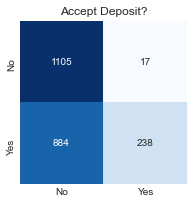

In [34]:
knn_model = KNeighborsClassifier(n_neighbors=300, weights = 'uniform', metric = 'manhattan')
knn_model.fit(X_train, y_train)
y_prob_knn = knn_model.predict_proba(X_test)
y_pred_knn = knn_model.predict(X_test)
conf_matrix(y_test,y_pred_knn)
get_scores(y_test,y_pred_knn, y_prob_knn[:, 1])

,scores
Accuracy,0.580
Precision,0.937
Recall,0.171
F1,0.289
ROC AUC,0.794


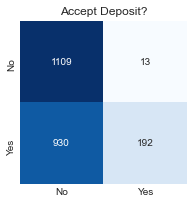

In [35]:
knn_model_full = KNeighborsClassifier(n_neighbors=300, weights = 'uniform', metric = 'manhattan')
knn_model_full.fit(X_train_full, y_train_full)
y_prob_knn_full = knn_model_full.predict_proba(X_test_full)
y_pred_knn_full = knn_model_full.predict(X_test_full)
conf_matrix(y_test_full,y_pred_knn_full)
get_scores(y_test_full,y_pred_knn_full, y_prob_knn_full[:, 1])

,scores
Accuracy,0.598
Precision,0.933
Recall,0.212
F1,0.346
ROC AUC,0.779


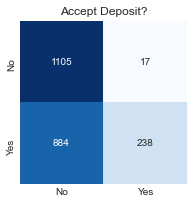

In [36]:
knn_model_over = KNeighborsClassifier(n_neighbors=300, weights = 'uniform', metric = 'manhattan')
t1 = time.time()
knn_model_over.fit(X_train_over, y_train_over)
y_prob_knn_over = knn_model_over.predict_proba(X_test)
y_pred_knn_over = knn_model.predict(X_test)
t2 = time.time()
t_knn = t2-t1
conf_matrix(y_test,y_pred_knn_over)
get_scores(y_test,y_pred_knn_over, y_prob_knn_over[:, 1])

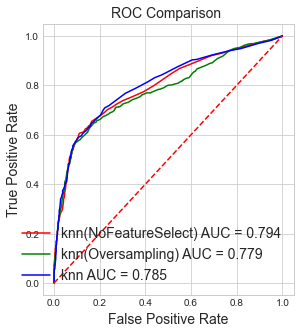

In [37]:
fprknn_over, tprknn_over, _ = roc_curve(y_test, y_prob_knn_over[:, 1])
fprknn_full, tprknn_full, _ = roc_curve(y_test, y_prob_knn_full[:, 1])
fprknn, tprknn, _ = roc_curve(y_test, y_prob_knn[:, 1])
roc_aucknn_full = auc(fprknn_full, tprknn_full)
roc_aucknn_over = auc(fprknn_over, tprknn_over)
roc_aucknn = auc(fprknn, tprknn)

fig = plt.figure(figsize=(4.5,5))
plt.plot(fprknn_full, tprknn_full, 'b', label='knn(NoFeatureSelect) AUC = %0.3f' % roc_aucknn_full,
        color='red')
plt.plot(fprknn_over, tprknn_over, 'b', label='knn(Oversampling) AUC = %0.3f' % roc_aucknn_over,
        color='green')
plt.plot(fprknn, tprknn, 'b', label='knn AUC = %0.3f' % roc_aucglr)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Comparison ',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.legend(loc = 'lower right', prop={'size': 14})

#### adaboost

,scores
Accuracy,0.588
Precision,0.946
Recall,0.186
F1,0.311
ROC AUC,0.802


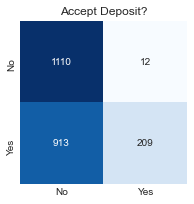

In [38]:
abc_model = AdaBoostClassifier(n_estimators=800, learning_rate=0.1, random_state=seed)
abc_model.fit(X_train, y_train)
y_prob_abc = abc_model.predict_proba(X_test)
y_pred_abc = abc_model.predict(X_test)
conf_matrix(y_test, y_pred_abc)
get_scores(y_test, y_pred_abc, y_prob_abc[:, 1])

,scores
Accuracy,0.590
Precision,0.943
Recall,0.193
F1,0.320
ROC AUC,0.803


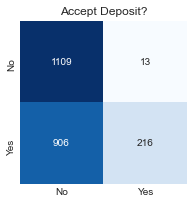

In [39]:
abc_model_full = AdaBoostClassifier(n_estimators=800, learning_rate=0.1, random_state=seed)
abc_model_full.fit(X_train_full, y_train_full)
y_prob_abc_full = abc_model_full.predict_proba(X_test_full)
y_pred_abc_full = abc_model_full.predict(X_test_full)
conf_matrix(y_test_full, y_pred_abc_full)
get_scores(y_test_full, y_pred_abc_full, y_prob_abc_full[:, 1])

,scores
Accuracy,0.743
Precision,0.815
Recall,0.628
F1,0.710
ROC AUC,0.801


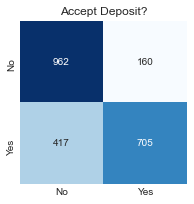

In [40]:
abc_model_over = AdaBoostClassifier(n_estimators=800, learning_rate=0.1, random_state=seed)
t1 = time.time()
abc_model_over.fit(X_train_over, y_train_over)
y_prob_abc_over = abc_model_over.predict_proba(X_test)
y_pred_abc_over = abc_model_over.predict(X_test)
t2 = time.time()
t_abc = t2-t1
conf_matrix(y_test, y_pred_abc_over)
get_scores(y_test, y_pred_abc_over, y_prob_abc_over[:, 1])

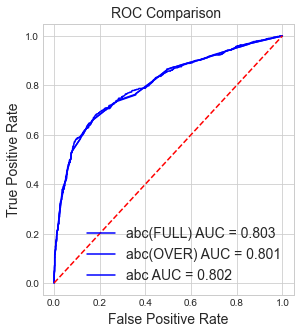

In [41]:
fprabc_over, tprabc_over, _ = roc_curve(y_test, y_prob_abc_over[:, 1])
fprabc_full, tprabc_full, _ = roc_curve(y_test, y_prob_abc_full[:, 1])
fprabc, tprabc, _ = roc_curve(y_test, y_prob_abc[:, 1])
roc_aucabc_full = auc(fprabc_full, tprabc_full)
roc_aucabc_over = auc(fprabc_over, tprabc_over)
roc_aucabc = auc(fprabc, tprabc)

fig = plt.figure(figsize=(4.5,5))
plt.plot(fprabc_full, tprabc_full, 'b', label='abc(FULL) AUC = %0.3f' % roc_aucabc_full)
plt.plot(fprabc_over, tprabc_over, 'b', label='abc(OVER) AUC = %0.3f' % roc_aucabc_over)
plt.plot(fprabc, tprabc, 'b', label='abc AUC = %0.3f' % roc_aucabc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Comparison ',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.legend(loc = 'lower right', prop={'size': 14})

#### xgboost

/Users/zhaoxingwu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:09:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { metrics } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,scores
Accuracy,0.607
Precision,0.941
Recall,0.228
F1,0.367
ROC AUC,0.809


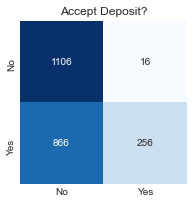

In [42]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, metrics="auc")
xgb_model.fit(X_train, y_train)
y_prob_xgb = xgb_model.predict_proba(X_test)
y_pred_xgb = xgb_model.predict(X_test)
conf_matrix(y_test, y_pred_xgb)
get_scores(y_test, y_pred_xgb, y_prob_xgb[:, 1])

/Users/zhaoxingwu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:09:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { metrics } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,scores
Accuracy,0.611
Precision,0.953
Recall,0.234
F1,0.375
ROC AUC,0.811


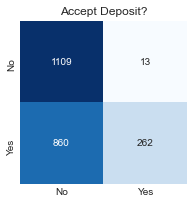

In [43]:
xgb_model_full = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, metrics="auc")
xgb_model_full.fit(X_train_full, y_train_full)
y_prob_xgb_full = xgb_model_full.predict_proba(X_test_full)
y_pred_xgb_full = xgb_model_full.predict(X_test_full)
conf_matrix(y_test_full, y_pred_xgb_full)
get_scores(y_test_full, y_pred_xgb_full, y_prob_xgb_full[:, 1])

/Users/zhaoxingwu/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:09:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { metrics } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,scores
Accuracy,0.738
Precision,0.822
Recall,0.607
F1,0.698
ROC AUC,0.807


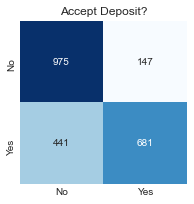

In [44]:
xgb_model_over = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, metrics="auc")
t1 = time.time()
xgb_model_over.fit(X_train_over, y_train_over)
y_prob_xgb_over = xgb_model_over.predict_proba(X_test)
y_pred_xgb_over = xgb_model_over.predict(X_test)
t2 = time.time()
t_xgb = t2-t1
conf_matrix(y_test, y_pred_xgb_over)
get_scores(y_test, y_pred_xgb_over, y_prob_xgb_over[:, 1])

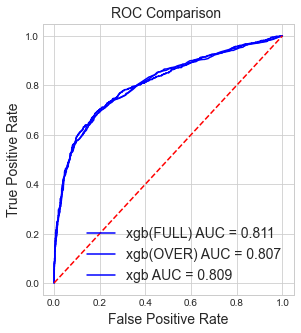

In [45]:
fprxgb_over, tprxgb_over, _ = roc_curve(y_test, y_prob_xgb_over[:, 1])
fprxgb_full, tprxgb_full, _ = roc_curve(y_test, y_prob_xgb_full[:, 1])
fprxgb, tprxgb, _ = roc_curve(y_test, y_prob_xgb[:, 1])
roc_aucxgb_full = auc(fprxgb_full, tprxgb_full)
roc_aucxgb_over = auc(fprxgb_over, tprxgb_over)
roc_aucxgb = auc(fprxgb, tprxgb)

fig = plt.figure(figsize=(4.5,5))
plt.plot(fprxgb_full, tprxgb_full, 'b', label='xgb(FULL) AUC = %0.3f' % roc_aucxgb_full)
plt.plot(fprxgb_over, tprxgb_over, 'b', label='xgb(OVER) AUC = %0.3f' % roc_aucxgb_over)
plt.plot(fprxgb, tprxgb, 'b', label='xgb AUC = %0.3f' % roc_aucxgb)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Comparison ',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.legend(loc = 'lower right', prop={'size': 14})

#### Decision Tree
Decision trees often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes.

,scores
Accuracy,0.740
Precision,0.816
Recall,0.619
F1,0.704
ROC AUC,0.789


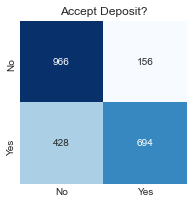

In [46]:
dtc_model = DecisionTreeClassifier(criterion = 'entropy', max_depth=6, min_samples_leaf=4,
                                   min_samples_split=2, random_state=seed, class_weight="balanced")
dtc_model.fit(X_train, y_train)
y_prob_dtc = dtc_model.predict_proba(X_test)
y_pred_dtc = dtc_model.predict(X_test)
conf_matrix(y_test, y_pred_dtc)
get_scores(y_test, y_pred_dtc, y_prob_dtc[:, 1])

,scores
Accuracy,0.731
Precision,0.836
Recall,0.574
F1,0.681
ROC AUC,0.778


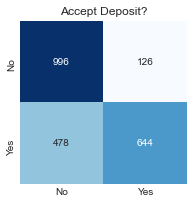

In [47]:
dtc_model_full = DecisionTreeClassifier(criterion = 'entropy', max_depth=6, min_samples_leaf=4,
                                   min_samples_split=2, random_state=seed, class_weight="balanced")
dtc_model_full.fit(X_train_full, y_train_full)
y_prob_dtc_full = dtc_model_full.predict_proba(X_test_full)
y_pred_dtc_full = dtc_model_full.predict(X_test_full)
conf_matrix(y_test_full, y_pred_dtc_full)
get_scores(y_test_full, y_pred_dtc_full, y_prob_dtc_full[:, 1])

,scores
Accuracy,0.732
Precision,0.834
Recall,0.578
F1,0.683
ROC AUC,0.791


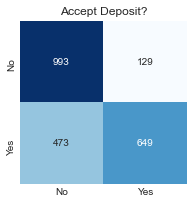

In [48]:
dtc_model_over = DecisionTreeClassifier(criterion = 'entropy', max_depth=6, min_samples_leaf=4,
                                   min_samples_split=2, random_state=seed, class_weight="balanced")
t1 = time.time()
dtc_model_over.fit(X_train_over, y_train_over)
y_prob_dtc_over = dtc_model_over.predict_proba(X_test)
y_pred_dtc_over = dtc_model_over.predict(X_test)
t2 = time.time()
t_dtc = t2-t1
conf_matrix(y_test, y_pred_dtc_over)
get_scores(y_test, y_pred_dtc_over, y_prob_dtc_over[:, 1])

In [49]:
from sklearn.tree import export_text
df_features.columns
print(export_text(dtc_model_over, feature_names=['housing', 'pdays', 'previous', 'emp.var.rate', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'contact_telephone', 'poutcome_nonexistent',
       'poutcome_success']))

|--- nr.employed <= -1.10
|   |--- pdays <= -5.08
|   |   |--- cons.conf.idx <= 1.38
|   |   |   |--- poutcome_success <= 0.50
|   |   |   |   |--- previous <= 6.72
|   |   |   |   |   |--- euribor3m <= -1.71
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- euribor3m >  -1.71
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- previous >  6.72
|   |   |   |   |   |--- cons.conf.idx <= -1.14
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- cons.conf.idx >  -1.14
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- poutcome_success >  0.50
|   |   |   |   |--- euribor3m <= -1.52
|   |   |   |   |   |--- euribor3m <= -1.71
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- euribor3m >  -1.71
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- euribor3m >  -1.52
|   |   |   |   |   |--- euribor3m <= -1.51
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- euribor3m >  -1.51
|   |   |   |   |   |   |--- class: 1
|   |   |--

In [50]:
print("> 10 features <")
print("max depth\t", dtc_model.tree_.max_depth)
print("node count\t", dtc_model.tree_.node_count)
print("n leaves\t", dtc_model.tree_.n_leaves)
print("> 38 features <")
print("max depth\t", dtc_model_full.tree_.max_depth)
print("node count\t", dtc_model_full.tree_.node_count)
print("n leaves\t", dtc_model_full.tree_.n_leaves)
print("> 10 features + oversampling <")
print("max depth\t", dtc_model_over.tree_.max_depth)
print("node count\t", dtc_model_over.tree_.node_count)
print("n leaves\t", dtc_model_over.tree_.n_leaves)

> 10 features <
max depth	 6
node count	 115
n leaves	 58
> 38 features <
max depth	 6
node count	 109
n leaves	 55
> 10 features + oversampling <
max depth	 6
node count	 119
n leaves	 60


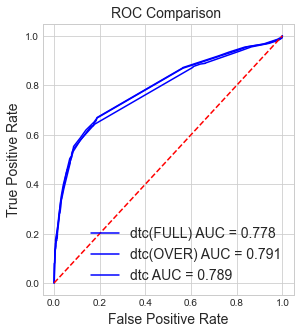

In [51]:
fprdtc_over, tprdtc_over, _ = roc_curve(y_test, y_prob_dtc_over[:, 1])
fprdtc_full, tprdtc_full, _ = roc_curve(y_test, y_prob_dtc_full[:, 1])
fprdtc, tprdtc, _ = roc_curve(y_test, y_prob_dtc[:, 1])
roc_aucdtc_full = auc(fprdtc_full, tprdtc_full)
roc_aucdtc_over = auc(fprdtc_over, tprdtc_over)
roc_aucdtc = auc(fprdtc, tprdtc)

fig = plt.figure(figsize=(4.5,5))
plt.plot(fprdtc_full, tprdtc_full, 'b', label='dtc(FULL) AUC = %0.3f' % roc_aucdtc_full)
plt.plot(fprdtc_over, tprdtc_over, 'b', label='dtc(OVER) AUC = %0.3f' % roc_aucdtc_over)
plt.plot(fprdtc, tprdtc, 'b', label='dtc AUC = %0.3f' % roc_aucdtc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Comparison ',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.legend(loc = 'lower right', prop={'size': 14})

#### Random Forest

,scores
Accuracy,0.740
Precision,0.832
Recall,0.601
F1,0.698
ROC AUC,0.807


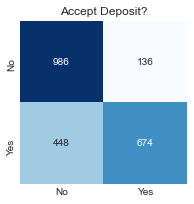

In [52]:
rfc_model = RandomForestClassifier(criterion='gini', max_depth=6, max_features='sqrt',
                                   n_estimators=200, class_weight="balanced")
rfc_model.fit(X_train, y_train)
y_prob_rfc = rfc_model.predict_proba(X_test)
y_pred_rfc = rfc_model.predict(X_test)
conf_matrix(y_test, y_pred_rfc)
get_scores(y_test, y_pred_rfc, y_prob_rfc[:, 1])

,scores
Accuracy,0.744
Precision,0.838
Recall,0.605
F1,0.703
ROC AUC,0.804


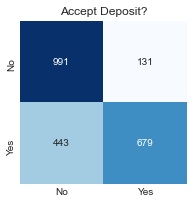

In [53]:
rfc_model_full = RandomForestClassifier(criterion='gini', max_depth=6, max_features='sqrt',
                                   n_estimators=200, class_weight="balanced")
rfc_model_full.fit(X_train_full, y_train_full)
y_prob_rfc_full = rfc_model_full.predict_proba(X_test_full)
y_pred_rfc_full = rfc_model_full.predict(X_test_full)
conf_matrix(y_test_full, y_pred_rfc_full)
get_scores(y_test_full, y_pred_rfc_full, y_prob_rfc_full[:, 1])

,scores
Accuracy,0.741
Precision,0.834
Recall,0.602
F1,0.699
ROC AUC,0.805


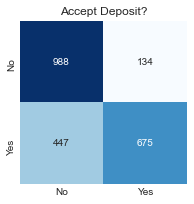

In [54]:
rfc_model_over = RandomForestClassifier(criterion='gini', max_depth=6, max_features='sqrt',
                                   n_estimators=200, class_weight="balanced")
t1 = time.time()
rfc_model_over.fit(X_train_over, y_train_over)
y_prob_rfc_over = rfc_model_over.predict_proba(X_test)
y_pred_rfc_over = rfc_model_over.predict(X_test)
t2 = time.time()
t_rfc = t2-t1
conf_matrix(y_test, y_pred_rfc_over)
get_scores(y_test, y_pred_rfc_over, y_prob_rfc_over[:, 1])

In [55]:
#fpr, tpr, _ = roc_curve(y_test, y_prob_[:, 1])
#roc_auc = auc(fpr, tpr)
fprglr, tprglr, _ = roc_curve(y_test, y_prob_glr[:, 1])
roc_aucglr = auc(fprglr, tprglr)
fprabc, tprabc, _ = roc_curve(y_test, y_prob_abc[:, 1])
roc_aucabc = auc(fprabc, tprabc)
fprknn, tprknn, _ = roc_curve(y_test, y_prob_knn[:, 1])
roc_aucknn = auc(fprknn, tprknn)
fprrfc, tprrfc, _ = roc_curve(y_test, y_prob_rfc[:, 1])
roc_aucrfc = auc(fprrfc, tprrfc)
fprxgb, tprxgb, _ = roc_curve(y_test, y_prob_xgb[:, 1])
roc_aucxgb = auc(fprxgb, tprxgb)
fprdtc, tprdtc, _ = roc_curve(y_test, y_prob_dtc[:, 1])
roc_aucdtc = auc(fprdtc, tprdtc)

In [56]:
fprglr_over, tprglr_over, _ = roc_curve(y_test, y_prob_glr_over[:, 1])
roc_aucglr_over = auc(fprglr_over, tprglr_over)
fprabc_over, tprabc_over, _ = roc_curve(y_test, y_prob_abc_over[:, 1])
roc_aucabc_over = auc(fprabc_over, tprabc_over)
fprknn_over, tprknn_over, _ = roc_curve(y_test, y_prob_knn_over[:, 1])
roc_aucknn_over = auc(fprknn_over, tprknn_over)
fprrfc_over, tprrfc_over, _ = roc_curve(y_test, y_prob_rfc_over[:, 1])
roc_aucrfc_over = auc(fprrfc_over, tprrfc_over)
fprxgb_over, tprxgb_over, _ = roc_curve(y_test, y_prob_xgb_over[:, 1])
roc_aucxgb_over = auc(fprxgb_over, tprxgb_over)
fprdtc_over, tprdtc_over, _ = roc_curve(y_test, y_prob_dtc_over[:, 1])
roc_aucdtc_over = auc(fprdtc_over, tprdtc_over)

In [57]:
fprglr_full, tprglr_full, _ = roc_curve(y_test_full, y_prob_glr_full[:, 1])
roc_aucglr_full = auc(fprglr, tprglr)
fprabc_full, tprabc_full, _ = roc_curve(y_test_full, y_prob_abc_full[:, 1])
roc_aucabc_full = auc(fprabc, tprabc)
fprknn_full, tprknn_full, _ = roc_curve(y_test_full, y_prob_knn_full[:, 1])
roc_aucknn_full = auc(fprknn, tprknn)
fprrfc_full, tprrfc_full, _ = roc_curve(y_test_full, y_prob_rfc_full[:, 1])
roc_aucrfc_full = auc(fprrfc, tprrfc)
fprxgb_full, tprxgb_full, _ = roc_curve(y_test_full, y_prob_xgb_full[:, 1])
roc_aucxgb_full = auc(fprxgb, tprxgb)
fprdtc_full, tprdtc_full, _ = roc_curve(y_test_full, y_prob_dtc_full[:, 1])
roc_aucdtc_full = auc(fprdtc, tprdtc)

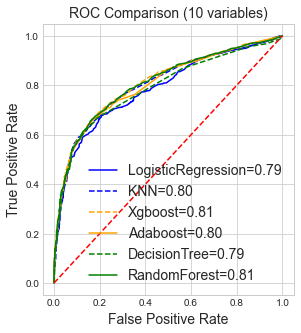

In [58]:
fig = plt.figure(figsize=(4.5,5))
plt.plot(fprglr, tprglr, 'b', label='LogisticRegression=%0.2f' % roc_aucglr)
plt.plot(fprknn, tprknn, 'b', label='KNN=%0.2f' % roc_aucknn, linestyle='dashed')
plt.plot(fprxgb, tprxgb, 'b', label='Xgboost=%0.2f' % roc_aucxgb, linestyle='dashed', color='orange')
plt.plot(fprabc, tprabc, 'b', label='Adaboost=%0.2f' % roc_aucabc, color='orange')
plt.plot(fprdtc, tprdtc, 'b', label='DecisionTree=%0.2f' % roc_aucdtc, linestyle='dashed', color='green')
plt.plot(fprrfc, tprrfc, 'b', label='RandomForest=%0.2f' % roc_aucrfc, color='green')
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Comparison (10 variables)',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.legend(loc = 'lower right', prop={'size': 14})

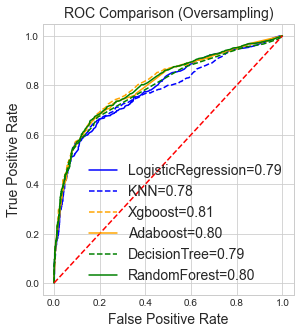

In [59]:
fig = plt.figure(figsize=(4.5,5))
plt.plot(fprglr_over, tprglr_over, 'b', label='LogisticRegression=%0.2f' % roc_aucglr_over)
plt.plot(fprknn_over, tprknn_over, 'b', label='KNN=%0.2f' % roc_aucknn_over, linestyle='dashed')
plt.plot(fprxgb_over, tprxgb_over, 'b', label='Xgboost=%0.2f' % roc_aucxgb_over, linestyle='dashed', color='orange')
plt.plot(fprabc_over, tprabc_over, 'b', label='Adaboost=%0.2f' % roc_aucabc_over, color='orange')
plt.plot(fprdtc_over, tprdtc_over, 'b', label='DecisionTree=%0.2f' % roc_aucdtc_over, linestyle='dashed', color='green')
plt.plot(fprrfc_over, tprrfc_over, 'b', label='RandomForest=%0.2f' % roc_aucrfc_over, color='green')
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Comparison (Oversampling)',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.legend(loc = 'lower right', prop={'size': 14})

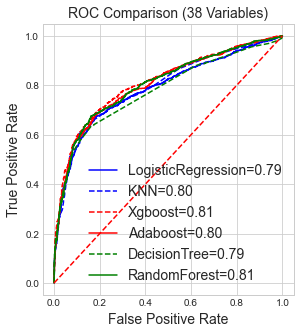

In [60]:
fig = plt.figure(figsize=(4.5,5))
plt.plot(fprglr_full, tprglr_full, 'b', label='LogisticRegression=%0.2f' % roc_aucglr_full)
plt.plot(fprknn_full, tprknn_full, 'b', label='KNN=%0.2f' % roc_aucknn_full, linestyle='dashed')
plt.plot(fprxgb_full, tprxgb_full, 'b', label='Xgboost=%0.2f' % roc_aucxgb_full, linestyle='dashed', color='red')
plt.plot(fprabc_full, tprabc_full, 'b', label='Adaboost=%0.2f' % roc_aucabc_full, color='red')
plt.plot(fprdtc_full, tprdtc_full, 'b', label='DecisionTree=%0.2f' % roc_aucdtc_full, linestyle='dashed', color='green')
plt.plot(fprrfc_full, tprrfc_full, 'b', label='RandomForest=%0.2f' % roc_aucrfc_full, color='green')
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Comparison (38 Variables)',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.legend(loc = 'lower right', prop={'size': 14})

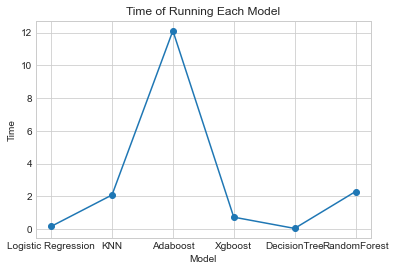

In [61]:
t = [t_glr, t_knn, t_abc, t_xgb, t_dtc, t_rfc]
model = ['Logistic Regression', 'KNN', 'Adaboost', 'Xgboost', 'DecisionTree', 'RandomForest']

plt.plot(model, t, marker='o')
 
# naming the x axis
plt.xlabel('Model')
# naming the y axis
plt.ylabel('Time')
 
# giving a title to my graph
plt.title('Time of Running Each Model')
 
# function to show the plot
plt.show()

In [62]:
f1_rfc_over = f1_score(y_test, y_pred_rfc_over)
f1_rfc_full = f1_score(y_test_full, y_pred_rfc_full)
f1_rfc = f1_score(y_test, y_pred_rfc_over)

f1_glr_over = f1_score(y_test, y_pred_glr_over)
f1_glr_full = f1_score(y_test_full, y_pred_glr_full)
f1_glr = f1_score(y_test, y_pred_glr)

f1_abc_over = f1_score(y_test, y_pred_abc_over)
f1_abc_full = f1_score(y_test_full, y_pred_abc_full)
f1_abc = f1_score(y_test, y_pred_abc)

f1_xgb_over = f1_score(y_test, y_pred_xgb_over)
f1_xgb_full = f1_score(y_test_full, y_pred_xgb_full)
f1_xgb = f1_score(y_test, y_pred_xgb)

f1_dtc_over = f1_score(y_test, y_pred_dtc_over)
f1_dtc_full = f1_score(y_test_full, y_pred_dtc_full)
f1_dtc = f1_score(y_test, y_pred_dtc)

f1_knn_over = f1_score(y_test, y_pred_knn_over)
f1_knn_full = f1_score(y_test_full, y_pred_knn_full)
f1_knn = f1_score(y_test, y_pred_knn)

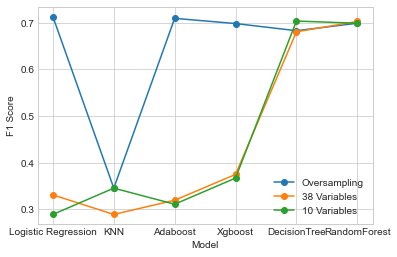

In [63]:
f1_over = [f1_glr_over, f1_knn_over, f1_abc_over, f1_xgb_over, f1_dtc_over, f1_rfc_over]
f1_full = [f1_glr_full, f1_knn_full, f1_abc_full, f1_xgb_full, f1_dtc_full, f1_rfc_full]
f1 = [f1_glr, f1_knn, f1_abc, f1_xgb, f1_dtc, f1_rfc]
plt.plot(model, f1_over, marker='o', label = "Oversampling")
plt.plot(model, f1_full, marker='o', label = "38 Variables")
plt.plot(model, f1, marker='o', label = "10 Variables")
# naming the x axis
plt.xlabel('Model')
# naming the y axis
plt.ylabel('F1 Score')
plt.legend()
# function to show the plot
plt.show()